# **Imports**

In [8]:
# torch
import torch
import torch.nn as nn
import torch.functional as F
from torch.utils.data import DataLoader
# augments
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
# utils
import os
from IPython.display import clear_output
import copy
# other
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import recall_score
import random
# warnings
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings(action='ignore', category=UndefinedMetricWarning)
# import py-scripts
import sys
sys.path.append("../")
from src.train_model import *
from src.utils import *
from src.get_model_funcs import *
from src.image_dataset import *
from src.img_transforms import *
from src.img_classifier_ensemble import *

In [3]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# **Dataset**

In [60]:
TRAIN_PATH = "/content/drive/MyDrive/hacksAI2022/Datasets/KarachaevoCherkessk/train"
TEST_PATH = "/content/drive/MyDrive/hacksAI2022/Datasets/KarachaevoCherkessk/test"
train_df = pd.read_csv("/content/drive/MyDrive/hacksAI2022/Datasets/KarachaevoCherkessk/train.csv")
test_df = pd.read_csv("/content/drive/MyDrive/hacksAI2022/Datasets/KarachaevoCherkessk/test.csv")
n_classes = len(train_df['class'].unique())
n_classes

In [18]:
# UPSAMPLING
upsampled_df = []
max_count = 600
for i in range(n_classes):
  class_df = train_df[train_df['class'] == i]
  if class_df.shape[0] < max_count:
    sum = class_df.shape[0]
    while sum < max_count:
      samples = train_df[train_df['class'] == i].sample(150)
      upsampled_df.append(samples)
      sum+=samples.shape[0]
upsampled_df.append(train_df)
upsampled_df = pd.concat(upsampled_df, axis=0).reset_index().drop('index', axis=1)
upsampled_df['class'].value_counts()

In [19]:
!mkdir augmented
transforms = A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.20, rotate_limit=30, p=1)
aug_df = augment_and_save(upsampled_df,750, TRAIN_PATH, "/content/augmented/",transforms)
!cd augmented && ls | wc -l
!cd /content/drive/MyDrive/hacksAI2022/Datasets/KarachaevoCherkessk/ && mkdir upsampled
!cp /content/drive/MyDrive/hacksAI2022/Datasets/KarachaevoCherkessk/train/* /content/drive/MyDrive/hacksAI2022/Datasets/KarachaevoCherkessk/upsampled
!cp /content/augmented/* /content/drive/MyDrive/hacksAI2022/Datasets/KarachaevoCherkessk/upsampled
augmented_df = pd.concat([train_df, aug_df])
print(augmented_df.shape)
augmented_df.to_csv('/content/drive/MyDrive/hacksAI2022/Datasets/KarachaevoCherkessk/upsampled.csv', index=False)

In [22]:
TRAIN_PATH = "/content/drive/MyDrive/hacksAI2022/Datasets/KarachaevoCherkessk/upsampled"
train_df = pd.read_csv('/content/drive/MyDrive/hacksAI2022/Datasets/KarachaevoCherkessk/upsampled.csv')

In [24]:
train_df['class'].value_counts()

1.0    1586
5.0    1178
6.0    1036
3.0     969
0.0     942
2.0     932
7.0     838
4.0     797
Name: class, dtype: int64

In [25]:
# UNDERSAMPLING
undersampled_df = []
max_count = 1000
for i in range(n_classes):
  if train_df[train_df['class'] == i].shape[0] > max_count:
    samples = train_df[train_df['class'] == i].sample(max_count)
    train_df = train_df.drop(train_df[train_df['class'] == i].index)
    undersampled_df.append(samples)
undersampled_df.append(train_df)
train_df = pd.concat(undersampled_df, axis=0)
train_df['class'].value_counts()

1.0    1000
5.0    1000
6.0    1000
3.0     969
0.0     942
2.0     932
7.0     838
4.0     797
Name: class, dtype: int64

In [29]:
train_df2, val_df2 = train_test_split(train_df,test_size=0.15, random_state=SEED)
#TRAIN DATA
train_dataset = ImgDataset(train_df2, TRAIN_PATH, transform=train_transforms, with_label=True)
train_dataloader = DataLoader(train_dataset, batch_size=70, shuffle=True, drop_last=True)

# VAL DATA
val_dataset = ImgDataset(val_df2, TRAIN_PATH, transform=test_transforms, with_label=True)
val_dataloader = DataLoader(val_dataset, batch_size=70, shuffle=True, drop_last=True)

# **CROSS-VALIDATION**

In [ ]:
cross_validation([],\
                 train_df, n_splits=5, \
                 batch_size=50,grad=True, transforms=[train_transforms, test_transforms],\
                 train_path=TRAIN_PATH, \
                 n_epochs=10,n_classes=n_classes, metric=recall_score, device=device)

# **TRAIN MODELS**

Epoch 10 val loss: 0.061
Epoch 10 val acc: 0.985
Epoch 10 val metric: 0.987


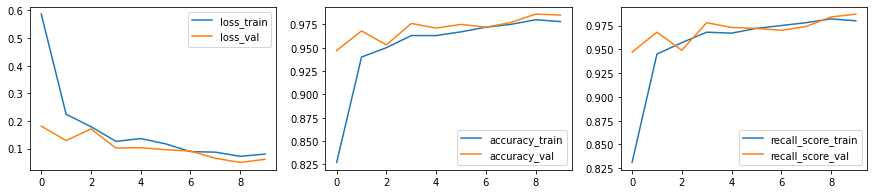

Best train loss: 0.072
Best val loss: 0.05
Best train metric: 0.982
Best val metric: 0.984


In [ ]:
efnet_v2s = get_efficientnet_v2_s_mod(n_classes, True)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(efnet_v2s.parameters(), lr=1.0e-3)

best_efnet_v2s, best_loss, best_metric = train_model(efnet_v2s,loss_func=loss,\
                                            train_dataloader=train_dataloader, \
                                            val_dataloader=val_dataloader,\
                                            optimizer=optimizer, n_epochs=10,\
                                            device=device,metric=recall_score,\
                                            )

In [ ]:
torch.save(best_efnet_v2s, "efnet_v2s.pth")

Epoch 10 val loss: 0.07
Epoch 10 val acc: 0.98
Epoch 10 val metric: 0.982
Find new best model on val with loss: 0.07, epoch: 10 !


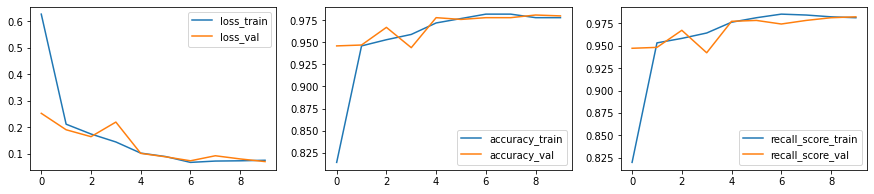

Best train loss: 0.067
Best val loss: 0.07
Best train metric: 0.985
Best val metric: 0.982


In [ ]:
efnet_b7 = get_efficientnet_b7_mod(n_classes, True)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(efnet_b7.parameters(), lr=1.0e-3)

best_efnet_b7, best_loss, best_metric = train_model(efnet_b7,loss_func=loss,\
                                            train_dataloader=train_dataloader, \
                                            val_dataloader=val_dataloader,\
                                            optimizer=optimizer, n_epochs=10,\
                                            device=device,metric=recall_score,\
                                            )

In [ ]:
torch.save(best_efnet_b7, "efnet_b7.pth")

Epoch 10 val loss: 0.114
Epoch 10 val acc: 0.964
Epoch 10 val metric: 0.966


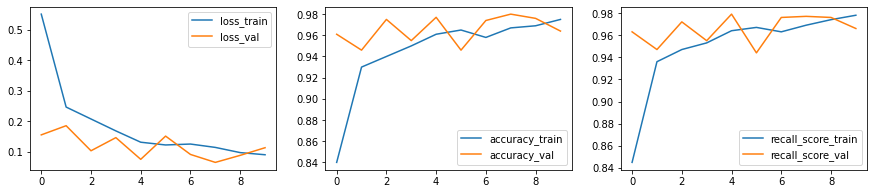

Best train loss: 0.091
Best val loss: 0.066
Best train metric: 0.978
Best val metric: 0.977


In [ ]:
resnet101 = get_wide_resnet101_mod(n_classes, True)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet101.parameters(), lr=1.0e-3)

best_resnet101, best_loss, best_metric = train_model(resnet101,loss_func=loss,\
                                            train_dataloader=train_dataloader, \
                                            val_dataloader=val_dataloader,\
                                            optimizer=optimizer, n_epochs=10,\
                                            device=device,metric=recall_score,\
                                            )

In [ ]:
torch.save(best_resnet101, "resnet101.pth")

Epoch 10 val loss: 0.1
Epoch 10 val acc: 0.97
Epoch 10 val metric: 0.973


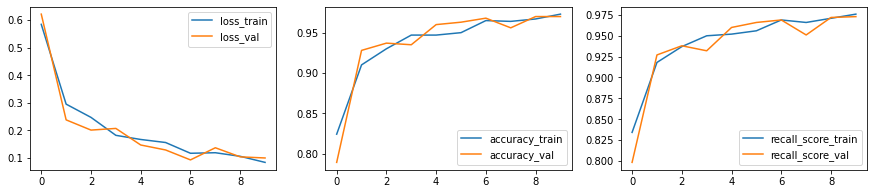

Best train loss: 0.084
Best val loss: 0.093
Best train metric: 0.976
Best val metric: 0.969


In [ ]:
densenet161 = get_densenet161_mod(n_classes, True)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(densenet161.parameters(), lr=1.0e-3)

best_densenet161, best_loss, best_metric = train_model(densenet161,loss_func=loss,\
                                            train_dataloader=train_dataloader, \
                                            val_dataloader=val_dataloader,\
                                            optimizer=optimizer, n_epochs=10,\
                                            device=device,metric=recall_score,\
                                            )

In [ ]:
torch.save(best_densenet161, "densenet161.pth")

Epoch 10 val loss: 0.108
Epoch 10 val acc: 0.967
Epoch 10 val metric: 0.967


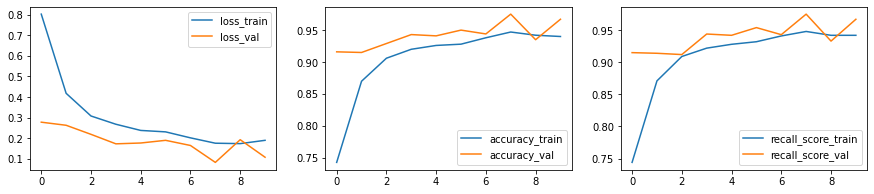

Best train loss: 0.174
Best val loss: 0.083
Best train metric: 0.942
Best val metric: 0.975


In [ ]:
swin_s = get_swin_s_mod(n_classes, True)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(swin_s.parameters(), lr=1.0e-3)

best_swin_s, best_loss, best_metric = train_model(swin_s,loss_func=loss,\
                                            train_dataloader=train_dataloader, \
                                            val_dataloader=val_dataloader,\
                                            optimizer=optimizer, n_epochs=10,\
                                            device=device,metric=recall_score,\
                                            )

In [ ]:
torch.save(best_swin_s, "swin_s.pth")

# **ENSEMBLE**

Epoch 20 val loss: 0.149
Epoch 20 val acc: 0.992
Epoch 20 val metric: 0.992
Find new best model on val with loss: 0.149, epoch: 20 !


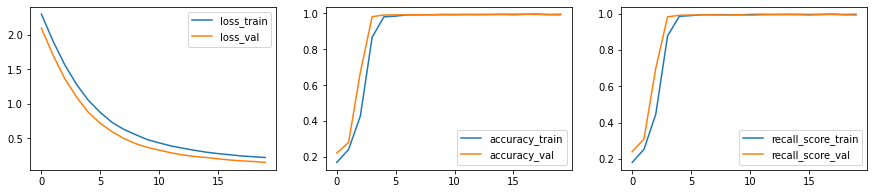

Best train loss: 0.22
Best val loss: 0.149
Best train metric: 0.996
Best val metric: 0.992


In [79]:
m_path = "/content/drive/MyDrive/hacksAI2022/Datasets/KarachaevoCherkessk/"
models_list = [
    torch.load(os.path.join(m_path, "resnet101.pth")), \
    torch.load(os.path.join(m_path, "efnet_b7.pth")),\
    torch.load(os.path.join(m_path, "swin_s.pth")),
    torch.load(os.path.join(m_path, "densenet161.pth")),
    torch.load(os.path.join(m_path, "efnet_v2s.pth"))
    ]

ensemble = ImgClassifiersEnsemble(models_list, n_classes )
loss = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(ensemble.parameters(), lr=1.0e-3)
optimizer = torch.optim.SGD(ensemble.parameters(), lr=1.0e-3)

for param in ensemble.parameters():
    param.requires_grad = False

for param in ensemble.classifier.parameters():
    param.requires_grad = True 

best_ensemble, best_loss, best_metric = train_model(ensemble,loss_func=loss,\
                                            train_dataloader=train_dataloader, \
                                            val_dataloader=val_dataloader,\
                                            optimizer=optimizer, n_epochs=35,\
                                            device=device,metric=recall_score,\
                                            )

In [ ]:
torch.save(best_ensemble, "ensemble_DN161_RN101_ENB7_ENV2S_SWIN.pth")

# **Predict and Submission** 

In [ ]:
submission_df = pd.read_csv("/content/drive/MyDrive/hacksAI2022/Datasets/KarachaevoCherkessk/test.csv")

In [81]:
test_dataset = ImgDataset(submission_df, TEST_PATH, transform=test_transforms, with_label=False)
test_dataloader = DataLoader(test_dataset, batch_size=20)

In [82]:
pred_labels, test_img_names = predict(best_ensemble, test_dataloader, device)

100%|██████████| 107/107 [00:39<00:00,  2.69it/s]


In [83]:
for name, label in zip(test_img_names, pred_labels):
  submission_df.loc[submission_df['ID_img'] == name , 'class'] = label

In [85]:
submission_df['class'].value_counts()

1    681
3    420
4    336
5    228
2    153
0    131
6    123
7     66
Name: class, dtype: int64

In [86]:
submission_df.to_csv('ensemble_upd_(SGD-20epochs)_DN161_RN101_ENB7_ENV2S_SWIN.csv', index=False)